# Sentiment Analysis

**The Problem**  While hikes on the WTA have an average star rating, the individual ratings are not available.  Since individual trip reports are present with username, I decided to attempt to create a sentiment analysis based rating for the trip reports.

**Methods Tried**
    - Sentiment analysis with algorithms that already exist in python:
        * TextBlob Polarity
        * Turi GraphLab Sentiment Analysis
    - Collecting training data from everytrail.com- each report also has a star rating and creating my own using the following methods:
        * Turi GraphLab Sentiment Analysis tool
        * Multinomial bayes sentiment analyzer built in python.

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
from src.sentimentAnalysis import detect_sentiment, setRating
import cPickle as pickle
from pymongo import MongoClient
from collections import defaultdict
import enchant
from nltk.corpus import stopwords
%matplotlib inline

In [13]:
connection = MongoClient()
db = connection.wta
tripReports = db.trip_reports

In [14]:
def mongo2PandasClean(mongodb, clean_creator=True, drop_id=True):
    df = pd.DataFrame(list(mongodb.find()))
    if drop_id:
        del df['_id']
    return df

In [15]:
df = mongo2PandasClean(tripReports)

In [18]:
df = df[df['hike_name']!='']

### Unpickle Hike identifier and id hikes

In [19]:
with open('../pickle/ider.pkl', 'rb') as f:
    ider = pickle.load(f)
df['hike_id'] = [ider[t.encode('utf-8')] for t in df['hike_name']]

In [20]:
df.head()

,Creator,Date,Rating,Text,hike_id,hike_name,author_id
0,amart005,"Jul 31, 2016",2,"The first meadow is a marshy mess, but after t...",0,Grand Park via Lake Eleanor,12474
1,xandwich,"Jul 26, 2016",3,Well...we got to Mount Rainier Tuesday morning...,0,Grand Park via Lake Eleanor,19586
2,HeatherD,"Jul 25, 2016",1,Found hiking poles at Lake Eleanor. Comment wi...,0,Grand Park via Lake Eleanor,4317
3,Lindy99,"Jul 24, 2016",4,"The WTA guide says this hike is 1,100 foot ele...",0,Grand Park via Lake Eleanor,6676
4,SpartanHiker,"Jul 23, 2016",4,Wonderful hike to Grand park. Overall the tra...,0,Grand Park via Lake Eleanor,10392


## Sentiment analysis

In [29]:
df['TextBlobSentiment'] = [detect_sentiment(t) for t in df['Text']]

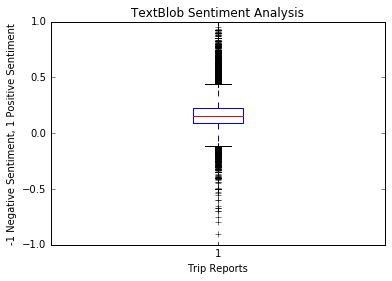

In [31]:
_=plt.boxplot(df.TextBlobSentiment)
plt.title('TextBlob Sentiment Analysis')
plt.ylabel('-1 Negative Sentiment, 1 Positive Sentiment')
plt.xlabel('Trip Reports')

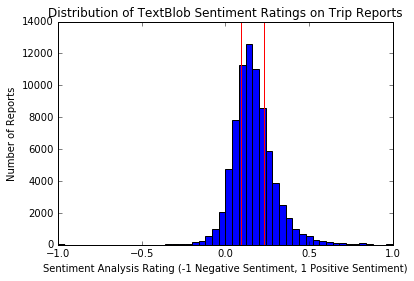

In [32]:
_=plt.hist(df['TextBlobSentiment'], bins=50)
plt.title('Distribution of TextBlob Sentiment Ratings on Trip Reports')
plt.vlines(np.percentile(df['TextBlobSentiment'], 25), 0, 14000, colors='red')
plt.vlines(np.percentile(df['TextBlobSentiment'], 75), 0, 14000, colors='red')
plt.ylabel('Number of Reports')
plt.xlabel('Sentiment Analysis Rating (-1 Negative Sentiment, 1 Positive Sentiment)')

In [48]:
df['Rating'] = setRating(df, 'TextBlobSentiment') 

In [34]:
hike_df = pd.read_csv('data/washington_hikes_clean_noout.csv')
hike_df = hike_df[['hike_id','stars']]

In [35]:
mean_text_ratings = df.groupby(by='hike_id').mean()

mean_text_ratings.head()

,Rating,author_id,TextBlobSentiment
hike_id,,,
0,3.309623,10214.899582,0.185290
1,3.000000,9227.500000,0.168322
2,2.111111,10932.185185,0.104747
3,3.000000,7689.600000,0.203857
4,2.600000,10487.400000,0.126434


In [36]:
merged_ratings = hike_df.merge(mean_text_ratings, left_on='hike_id', right_index=True).drop(labels=['author_id','TextBlobSentiment'],axis=1)

In [37]:
merged_ratings.head()

,hike_id,stars,Rating
0,0,4.25,3.309623
1,1,2.33,3.000000
2,2,3.00,2.111111
3,3,3.67,3.000000
4,4,2.75,2.600000


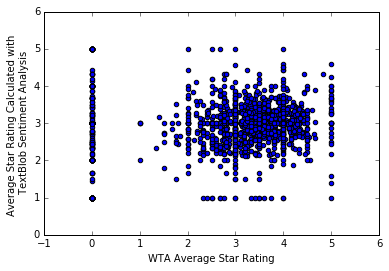

In [38]:
plt.scatter(merged_ratings['stars'], merged_ratings['Rating'])
plt.xlabel('WTA Average Star Rating')
plt.ylabel('Average Star Rating Calculated with \n TextBlob Sentiment Analysis')

In [39]:
merged_ratings.corr()

,hike_id,stars,Rating
hike_id,1.000000,-0.133472,-0.063709
stars,-0.133472,1.000000,0.097723
Rating,-0.063709,0.097723,1.000000


## Using Dato Graphlab sentiment analysis:

https://turi.com/products/create/docs/generated/graphlab.sentiment_analysis.create.html#graphlab.sentiment_analysis.create


In [40]:
import graphlab as gl

In [41]:
#df = df.dropna()
df['hike_id'] = df['hike_id'].fillna(np.nan).astype(int)
df['author_id'] = df['author_id'].fillna(np.nan).astype(int)
sf = gl.SFrame(df)

In [42]:
m = gl.sentiment_analysis.create(sf, features=['Text'])

In [43]:
df['GraphLabSentiment'] = m.predict(sf)

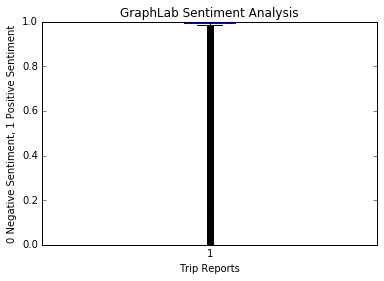

In [44]:
_=plt.boxplot(df['GraphLabSentiment'])
plt.title('GraphLab Sentiment Analysis')
plt.ylabel('0 Negative Sentiment, 1 Positive Sentiment')
plt.xlabel('Trip Reports')

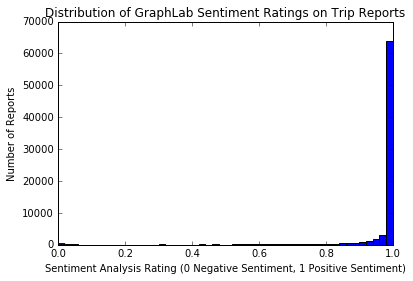

In [45]:
_=plt.hist(df['GraphLabSentiment'], bins=50)
plt.title('Distribution of GraphLab Sentiment Ratings on Trip Reports')
plt.ylabel('Number of Reports')
plt.xlabel('Sentiment Analysis Rating (0 Negative Sentiment, 1 Positive Sentiment)')

In [46]:
for row in df['Text'][df['GraphLabSentiment']<0.2].head(10):
    print row
    print '\n'

 There was a group of people who had a dog at Grand Park.  When we told them dogs aren't allowed they first claimed that they didn't see the signs, then changed their story and claimed it was a "comfort animal".  My wife got pretty vocal with the dingbats, and then as we were parting ways the old guy in the group shouted out, "Go Bernie!!"  I was perplexed at what exactly that could mean.  At first I thought he was a Bernie supporter, but upon further reflection I think it was meant as some sort of insult.  Hard to tell.  I replied, "Make America great again!!" and we headed on down the trail while the old guy dropped f-bombs in our general direction.  Just another lovely day in nature.


Maybe I'm just an idiot or the directions aren't very clear. I could not find this hike after searching for 3 hours, wasted my entire day. Even asked park rangers if they knew about this hike and they never heard about it, we looked it up on this website and the park ranger was completely confused as 

## Attempting GraphLab's sentiment analysis with scraped TR training data

Using data gathered from everytrail.com

In [ ]:
connection.close()

In [ ]:
train = db.trainingTR
train_df = mongo2PandasClean(train, clean_creator=False)

In [ ]:
train_df.info()

In [ ]:
train_df['Rating'] = [int(r) for r in train_df['Rating']]

In [ ]:
_=plt.boxplot(train_df.Rating)
plt.title('Training Text Ratings')
plt.ylabel('Number of Stars')
plt.xlabel('Trip Reports')

In [ ]:
_=plt.hist(train_df.Rating, bins=50)
plt.title('Distribution of Star Ratings on EveryTrail.com Trip Reports')
plt.ylabel('Number of Reports')
plt.xlabel('Number of Stars')

In [ ]:
train_df.Rating.value_counts()

In [ ]:
train_df.head()

In [ ]:
train_sf = gl.SFrame(train_df)

In [ ]:
trained_model = gl.sentiment_analysis.create(train_sf, target='Rating', features=['Text'], method='bow-logistic')

In [ ]:
df['TrainedModelSentiment'] = trained_model.predict(sf)

In [ ]:
_=plt.boxplot(df['TrainedModelSentiment'])
plt.title('Trained Model Sentiment Analysis')
plt.ylabel('0 Negative Sentiment, 1 Positive Sentiment')
plt.xlabel('Trip Reports')

In [ ]:
_=plt.hist(df['TrainedModelSentiment'], bins=50)
plt.title('Distribution of Trained GraphLab Sentiment Ratings on Trip Reports, Trained on everytrail.com Data')
plt.ylabel('Number of Reports')
plt.xlabel('Sentiment Analysis Rating (0 Negative Sentiment, 1 Positive Sentiment)')

### With Oversampling?

In [ ]:
#Find rows with ratings of 3 or less.
neg_rows = train_df[train_df['Rating'] < 4].index.tolist()
pos_rows = train_df[train_df['Rating'] > 3].index.tolist()

In [ ]:
#To start with, lets get random sampling from both the positive and negative reviews

neg_reviews = train_df.ix[np.random.choice(neg_rows, size=500, replace=True)]
neg_reviews['Rating'] = [1 for r in neg_reviews['Rating']]
pos_reviews = train_df.ix[np.random.choice(pos_rows, size=500, replace=True)]
pos_reviews['Rating'] = [5 for r in pos_reviews['Rating']]

In [ ]:
neg_reviews.tail()

In [ ]:
neg_reviews.head()

In [ ]:
train_df.ix[neg_rows]

In [ ]:
#Maybe try using trip reports with poor ratigs 

In [38]:
df.head()

,Creator,Date,Text,hike_name,author_id,hike_id,TextBlobSentiment,Rating
0,amart005,"Jul 31, 2016","The first meadow is a marshy mess, but after t...",Grand Park via Lake Eleanor,12474,0,0.125246,3
1,xandwich,"Jul 26, 2016",Well...we got to Mount Rainier Tuesday morning...,Grand Park via Lake Eleanor,19586,0,0.151480,3
2,HeatherD,"Jul 25, 2016",Found hiking poles at Lake Eleanor. Comment wi...,Grand Park via Lake Eleanor,4317,0,0.000000,1
3,Lindy99,"Jul 24, 2016","The WTA guide says this hike is 1,100 foot ele...",Grand Park via Lake Eleanor,6676,0,0.225347,3
4,SpartanHiker,"Jul 23, 2016",Wonderful hike to Grand park. Overall the tra...,Grand Park via Lake Eleanor,10392,0,0.215000,3


## Attempting word graphs as seen in 
http://varianceexplained.org/r/yelp-sentiment/

In [22]:
def addWordScores(text, rating, def_dict):
    for word in text.lower().strip().split():
        def_dict[word.strip(string.punctuation)].append(rating)
    return def_dict           

In [36]:
def WordScoretoPandasDF(df, text_col='Text', rating_col='Rating', drop_numbers=True):
    wordRatingTBS = defaultdict(list)
    for i in df.index.tolist():
        wordRatingTBS = addWordScores(df[text_col][i], df[rating_col][i], wordRatingTBS)
    avegWordRatingTBS = dict()
    cntWordRatingTBS = dict()
    for k, v in wordRatingTBS.iteritems():
        avegWordRatingTBS[k] = np.mean(v)
        cntWordRatingTBS[k] = len(v)
    words = pd.DataFrame(avegWordRatingTBS.items(), columns=['Words', 'Average Rating'])
    words['Number of Occurences'] = [cntWordRatingTBS[w] for w in words['Words']]
    words = words.ix[1:]
    return words

In [37]:
def dropNonWords(df, column):
    i_tokeep = []
    d = enchant.Dict("en_US")
    for i, w in enumerate(df[column]):
        if not d.check(w):
            i_tokeep.append(i)
    return df.ix[i_tokeep]
            

In [43]:
def dropStopWords(df, column):
    i_tokeep = []
    for i, w in enumerate(df[column]):
        if w not in stopwords.words('english'):
            i_tokeep.append(i)
    return df.ix[i_tokeep]
            

In [44]:
TBS = WordScoretoPandasDF(df, rating_col='TextBlobSentiment')

In [45]:
TBS.head()

,Words,Average Rating,Number of Occurences
1,fawn,0.147966,135
2,ago.first,0.146289,1
3,fine....overall,0.067201,4
4,35mi,0.085947,2
5,wooda,0.256230,1


In [46]:
TBS = dropNonWords(TBS, 'Words')

In [47]:
TBS = dropStopWords(TBS, 'Words')

In [50]:
TBS.head(20)

,Words,Average Rating,Number of Occurences
1,fawn,0.147966,135.0
2,ago.first,0.146289,1.0
3,fine....overall,0.067201,4.0
4,35mi,0.085947,2.0
6,"1,800",0.143590,41.0
7,saturday.river,0.098958,1.0
8,sowell,0.166288,1.0
9,creek/crevasses,0.114670,1.0
11,gag,0.126038,6.0
15,spiders,0.136251,65.0


In [49]:
TBS.dropna(inplace=True)

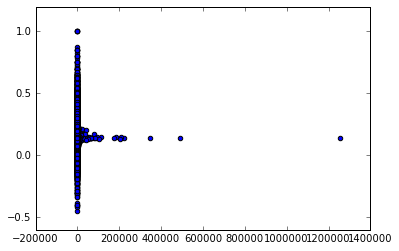

In [51]:
plt.scatter(TBS['Number of Occurences'], TBS['Average Rating'])

In [ ]:
TBS[TBS['Number of Occurences']>5000]

In [ ]:
word = 'has'
word in stopwords.words('english')

In [ ]:
wordRatingTMS = defaultdict(list)
for i in df.index.to_list:
    wordRatingsTMS = addWordScores(train_df['Text'][i], train_df['Rating'][i], wordRatingsTMS)
   


## To CSV

In [ ]:
### Rewriting mongodb
db.trip_reports.drop()
for i in range(len(df)):
    db.ratings.insert({'Creator': df['Creator'][i], 'Date': df['Date'][i], 'hike_name': df['Name'][i], 'Text': df['Text'][i],
                       'author_id':df['author_id'][i], 'hike_id': df['hike_id'][i], 'Rating':df['Rating'][i]})

In [52]:
df.drop(labels=['TextBlobSentiment', 'GraphLabSentiment'], axis=1, inplace=True)

In [53]:
df.to_csv('data/tripReports.csv',  encoding='utf-8', )